In [93]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import requests
import json
from bs4 import BeautifulSoup
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt

In [94]:
all_seasons = []

for season in range(2021, 2024):
    summary_url = f"https://api.nhle.com/stats/rest/en/skater/summary?limit=-1&cayenneExp=seasonId={season}{season+1}%20and%20gameTypeId=2"

    try:
        summary_resp = requests.get(summary_url)
        summary_resp.raise_for_status() 
        summary_json =  summary_resp.json()

        if summary_json['data']:
            df_summary = DataFrame(summary_json['data'])
            all_seasons.append(df_summary)
            df_summary['season'] = f"{season}-{season + 1}"
            print(f"Successfully fetched data for season {season}-{season+1}")
        else:
            print(f"No data returned for season {season}-{season + 1}")
        
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data for season {season}-{season + 1}: {e}")

if all_seasons:
    nhl_api_df = pd.concat(all_seasons, ignore_index=True)
    nhl_api_df = nhl_api_df.groupby('playerId').agg({
            'playerId': 'first',
            'skaterFullName': 'first',
            'positionCode': 'first',
            'gamesPlayed': 'sum',
            'otGoals': 'sum',
            'gameWinningGoals': 'sum',
        }).reset_index(drop = True)
    
print(nhl_api_df)

Successfully fetched data for season 2021-2022
Successfully fetched data for season 2022-2023
Successfully fetched data for season 2023-2024
      playerId     skaterFullName positionCode  gamesPlayed  otGoals  \
0      8465009        Zdeno Chara            D           72        0   
1      8466138       Joe Thornton            C           34        0   
2      8469455       Jason Spezza            C           71        0   
3      8470281       Duncan Keith            D           64        0   
4      8470595         Eric Staal            C           72        0   
...        ...                ...          ...          ...      ...   
1250   8484314       Jiri Smejkal            L           20        0   
1251   8484321  Nikolas Matinpalo            D            4        0   
1252   8484325    Waltteri Merela            C           19        0   
1253   8484326        Patrik Koch            D            1        0   
1254   8484911        Collin Graf            R            7        

In [95]:
nhl_api_df = nhl_api_df.loc[(nhl_api_df['positionCode'] != 'D') & (nhl_api_df['gamesPlayed'] >= 60)]
nhl_api_df = nhl_api_df.reset_index(drop = True)
nhl_api_df = nhl_api_df.fillna(0)

nhl_api_df.rename(columns = {'gameWinningGoals': 'game_winning_goals'}, inplace = True)
nhl_api_df.rename(columns = {'otGoals': 'ot_goals'}, inplace = True)
nhl_api_df.rename(columns = {'skaterFullName': 'Player'}, inplace = True)

In [96]:
goals_up_one_url = "https://www.naturalstattrick.com/playerteams.php?fromseason=20212022&thruseason=20232024&stype=2&sit=all&score=u1&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
goals_down_one_url = "https://www.naturalstattrick.com/playerteams.php?fromseason=20212022&thruseason=20232024&stype=2&sit=all&score=d1&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
tied_url = "https://www.naturalstattrick.com/playerteams.php?fromseason=20212022&thruseason=20232024&stype=2&sit=all&score=tied&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
total_url = "https://www.naturalstattrick.com/playerteams.php?fromseason=20212022&thruseason=20232024&stype=2&sit=all&score=all&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"

In [97]:
urls = {
    "goals_up_one": ("https://www.naturalstattrick.com/playerteams.php?fromseason=20212022&thruseason=20232024&stype=2&sit=all&score=u1&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL", 'goals_up_by_one'),
    "goals_down_one": ("https://www.naturalstattrick.com/playerteams.php?fromseason=20212022&thruseason=20232024&stype=2&sit=all&score=d1&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL", 'goals_down_by_one'),
    "tied": ("https://www.naturalstattrick.com/playerteams.php?fromseason=20212022&thruseason=20232024&stype=2&sit=all&score=tied&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL", 'goals_when_tied'),
    "total": ("https://www.naturalstattrick.com/playerteams.php?fromseason=20212022&thruseason=20232024&stype=2&sit=all&score=all&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL", 'total_goals')
}

dataframes = {}

for name, (url, new_column_name) in urls.items():
    df = pd.read_html(url, header=0, index_col=0, na_values=["-"])[0]
    df.rename(columns={'Goals': new_column_name}, inplace=True)
    dataframes[name] = df

goals_up_one_df = dataframes["goals_up_one"]
goals_down_one_df = dataframes["goals_down_one"]
goals_tied_df = dataframes["tied"]
total_df = dataframes["total"]


In [98]:
merged_natural_stat = pd.merge(pd.merge(goals_up_one_df[['Player', 'GP', 'goals_up_by_one']],goals_down_one_df[['Player', 'goals_down_by_one']],on='Player'),goals_tied_df[['Player', 'goals_when_tied']],on='Player')
merged_natural_stat = merged_natural_stat.loc[merged_natural_stat['GP'] >= 60]

In [99]:
merged_natural_stat

,Player,GP,goals_up_by_one,goals_down_by_one,goals_when_tied
1,Jason Spezza,71,2,4,1
2,Eric Staal,72,3,2,3
3,Jeff Carter,227,12,10,9
4,Dustin Brown,64,1,2,2
5,Zach Parise,194,3,6,12
...,...,...,...,...,...
759,Juraj Slafkovsky,121,2,5,6
764,Ben Meyers,67,0,1,2
769,Andrei Kuzmenko,153,8,13,18
772,Connor Bedard,68,2,6,9


In [100]:
natural_stat_names = ["Pat Maroon", "Alex Kerfoot", "Nicholas Paul", "Zach Sanford", "Alex Wennberg", "Mitchell Marner", "Zach Aston-Reese",  "Max Comtois", "Alexei Toropchenko"]
nhl_names = ["Patrick Maroon", "Alexander Kerfoot", "Nick Paul", "Zachary Sanford", "Alexander Wennberg", "Mitch Marner", "Zachary Aston-Reese",  "Maxime Comtois", "Alexey Toropchenko"]
merged_natural_stat = merged_natural_stat.replace(natural_stat_names, nhl_names)

In [101]:
merged_natural_stat

,Player,GP,goals_up_by_one,goals_down_by_one,goals_when_tied
1,Jason Spezza,71,2,4,1
2,Eric Staal,72,3,2,3
3,Jeff Carter,227,12,10,9
4,Dustin Brown,64,1,2,2
5,Zach Parise,194,3,6,12
...,...,...,...,...,...
759,Juraj Slafkovsky,121,2,5,6
764,Ben Meyers,67,0,1,2
769,Andrei Kuzmenko,153,8,13,18
772,Connor Bedard,68,2,6,9


In [102]:
nhl_api_df

,playerId,Player,positionCode,gamesPlayed,ot_goals,game_winning_goals
0,8469455,Jason Spezza,C,71,0,1
1,8470595,Eric Staal,C,72,0,1
2,8470604,Jeff Carter,C,227,2,8
3,8470606,Dustin Brown,R,64,0,0
4,8470610,Zach Parise,L,194,1,7
...,...,...,...,...,...,...
508,8483515,Juraj Slafkovsky,L,121,0,2
509,8483570,Ben Meyers,C,67,0,0
510,8483808,Andrei Kuzmenko,L,153,3,8
511,8484144,Connor Bedard,C,68,1,2


In [103]:
merged_clutch_goals = nhl_api_df.merge(merged_natural_stat, on = 'Player', how = 'left')

In [104]:
merged_clutch_goals

,playerId,Player,positionCode,gamesPlayed,ot_goals,game_winning_goals,GP,goals_up_by_one,goals_down_by_one,goals_when_tied
0,8469455,Jason Spezza,C,71,0,1,71,2,4,1
1,8470595,Eric Staal,C,72,0,1,72,3,2,3
2,8470604,Jeff Carter,C,227,2,8,227,12,10,9
3,8470606,Dustin Brown,R,64,0,0,64,1,2,2
4,8470610,Zach Parise,L,194,1,7,194,3,6,12
...,...,...,...,...,...,...,...,...,...,...
508,8483515,Juraj Slafkovsky,L,121,0,2,121,2,5,6
509,8483570,Ben Meyers,C,67,0,0,67,0,1,2
510,8483808,Andrei Kuzmenko,L,153,3,8,153,8,13,18
511,8484144,Connor Bedard,C,68,1,2,68,2,6,9


In [105]:
if (merged_clutch_goals['gamesPlayed'] == merged_clutch_goals['GP']).all():
    print("Merge correct")

Merge correct


In [106]:
null_rows = merged_clutch_goals[merged_clutch_goals.isnull().any(axis=1)]
print("Rows with null values:")
print(null_rows)

Rows with null values:
Empty DataFrame
Columns: [playerId, Player, positionCode, gamesPlayed, ot_goals, game_winning_goals, GP, goals_up_by_one, goals_down_by_one, goals_when_tied]
Index: []


In [107]:
merged_clutch_goals.drop(columns = 'GP', axis = 1, inplace = True)
merged_clutch_goals


,playerId,Player,positionCode,gamesPlayed,ot_goals,game_winning_goals,goals_up_by_one,goals_down_by_one,goals_when_tied
0,8469455,Jason Spezza,C,71,0,1,2,4,1
1,8470595,Eric Staal,C,72,0,1,3,2,3
2,8470604,Jeff Carter,C,227,2,8,12,10,9
3,8470606,Dustin Brown,R,64,0,0,1,2,2
4,8470610,Zach Parise,L,194,1,7,3,6,12
...,...,...,...,...,...,...,...,...,...
508,8483515,Juraj Slafkovsky,L,121,0,2,2,5,6
509,8483570,Ben Meyers,C,67,0,0,0,1,2
510,8483808,Andrei Kuzmenko,L,153,3,8,8,13,18
511,8484144,Connor Bedard,C,68,1,2,2,6,9


In [108]:
merged_clutch_goals

,playerId,Player,positionCode,gamesPlayed,ot_goals,game_winning_goals,goals_up_by_one,goals_down_by_one,goals_when_tied
0,8469455,Jason Spezza,C,71,0,1,2,4,1
1,8470595,Eric Staal,C,72,0,1,3,2,3
2,8470604,Jeff Carter,C,227,2,8,12,10,9
3,8470606,Dustin Brown,R,64,0,0,1,2,2
4,8470610,Zach Parise,L,194,1,7,3,6,12
...,...,...,...,...,...,...,...,...,...
508,8483515,Juraj Slafkovsky,L,121,0,2,2,5,6
509,8483570,Ben Meyers,C,67,0,0,0,1,2
510,8483808,Andrei Kuzmenko,L,153,3,8,8,13,18
511,8484144,Connor Bedard,C,68,1,2,2,6,9


In [109]:
columns = ['ot_goals', 'game_winning_goals', 'goals_up_by_one', 'goals_down_by_one', 'goals_when_tied']
for column in columns:
    per_game_string = f"{column}_per_game"
    merged_clutch_goals[per_game_string] = merged_clutch_goals[column] / merged_clutch_goals['gamesPlayed']


In [110]:
merged_clutch_goals['clutch_score'] =  0.25 * merged_clutch_goals['goals_when_tied_per_game'] + 0.25 * merged_clutch_goals['goals_down_by_one_per_game'] + 0.2 * merged_clutch_goals['goals_up_by_one_per_game'] + 0.15 * merged_clutch_goals['ot_goals_per_game'] + 0.15 * merged_clutch_goals['game_winning_goals_per_game'] 

In [111]:
merged_clutch_goals

,playerId,Player,positionCode,gamesPlayed,ot_goals,game_winning_goals,goals_up_by_one,goals_down_by_one,goals_when_tied,ot_goals_per_game,game_winning_goals_per_game,goals_up_by_one_per_game,goals_down_by_one_per_game,goals_when_tied_per_game,clutch_score
0,8469455,Jason Spezza,C,71,0,1,2,4,1,0.000000,0.014085,0.028169,0.056338,0.014085,0.025352
1,8470595,Eric Staal,C,72,0,1,3,2,3,0.000000,0.013889,0.041667,0.027778,0.041667,0.027778
2,8470604,Jeff Carter,C,227,2,8,12,10,9,0.008811,0.035242,0.052863,0.044053,0.039648,0.038106
3,8470606,Dustin Brown,R,64,0,0,1,2,2,0.000000,0.000000,0.015625,0.031250,0.031250,0.018750
4,8470610,Zach Parise,L,194,1,7,3,6,12,0.005155,0.036082,0.015464,0.030928,0.061856,0.032474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
508,8483515,Juraj Slafkovsky,L,121,0,2,2,5,6,0.000000,0.016529,0.016529,0.041322,0.049587,0.028512
509,8483570,Ben Meyers,C,67,0,0,0,1,2,0.000000,0.000000,0.000000,0.014925,0.029851,0.011194
510,8483808,Andrei Kuzmenko,L,153,3,8,8,13,18,0.019608,0.052288,0.052288,0.084967,0.117647,0.071895
511,8484144,Connor Bedard,C,68,1,2,2,6,9,0.014706,0.029412,0.029412,0.088235,0.132353,0.067647


In [116]:
merged_clutch_goals['clutch_score_rank']  = merged_clutch_goals['clutch_score'].rank(ascending = False)
merged_clutch_goals.sort_values('clutch_score_rank', inplace = True)
merged_clutch_goals.head(20)

,playerId,Player,positionCode,gamesPlayed,ot_goals,game_winning_goals,goals_up_by_one,goals_down_by_one,goals_when_tied,ot_goals_per_game,game_winning_goals_per_game,goals_up_by_one_per_game,goals_down_by_one_per_game,goals_when_tied_per_game,clutch_score,clutch_score_rank
318,8479318,Auston Matthews,C,228,5,26,32,30,56,0.021930,0.114035,0.140351,0.131579,0.245614,0.142763,1.0
236,8477956,David Pastrnak,R,236,5,27,31,18,65,0.021186,0.114407,0.131356,0.076271,0.275424,0.134534,2.0
222,8477934,Leon Draisaitl,C,241,4,29,28,25,50,0.016598,0.120332,0.116183,0.103734,0.207469,0.121577,3.0
267,8478402,Connor McDavid,C,238,7,25,28,27,44,0.029412,0.105042,0.117647,0.113445,0.184874,0.118277,4.0
304,8478864,Kirill Kaprizov,L,223,6,19,21,28,45,0.026906,0.085202,0.094170,0.125561,0.201794,0.117489,5.0
264,8478398,Kyle Connor,L,226,6,27,27,12,45,0.026549,0.119469,0.119469,0.053097,0.199115,0.108850,6.0
152,8476887,Filip Forsberg,L,201,4,21,18,19,39,0.019900,0.104478,0.089552,0.094527,0.194030,0.108706,7.0
274,8478427,Sebastian Aho,C,232,6,28,31,15,40,0.025862,0.120690,0.133621,0.064655,0.172414,0.107974,8.0
201,8477492,Nathan MacKinnon,C,218,5,23,30,17,36,0.022936,0.105505,0.137615,0.077982,0.165138,0.107569,9.0
453,8481559,Jack Hughes,C,189,5,12,18,16,36,0.026455,0.063492,0.095238,0.084656,0.190476,0.101323,10.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


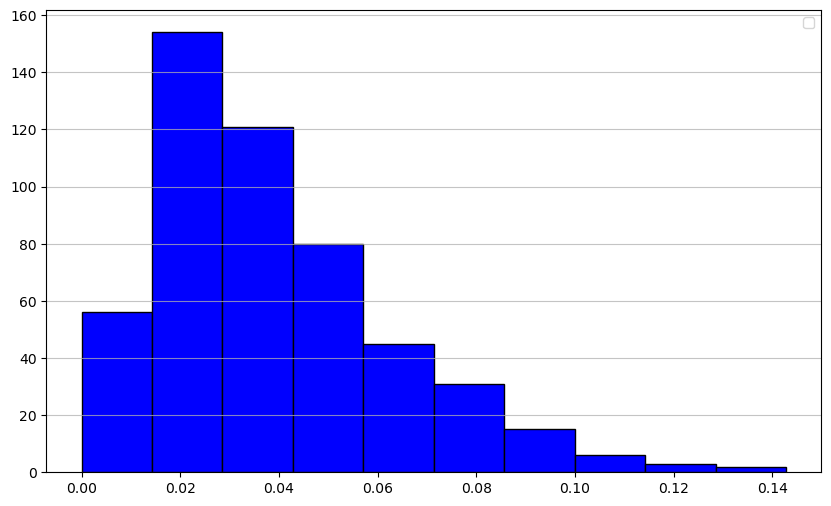

In [113]:
plt.figure(figsize=(10, 6))
plt.hist(merged_clutch_goals['clutch_score'], color='blue', edgecolor='black')
plt.grid(axis='y', alpha=0.75)
plt.legend()
plt.show()